### 2023A for my LDSS3 proposal. Only blue UPGs.

In [3]:
# Import packages
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [222]:
import os
import dill, sys
import copy
import numpy as np
import matplotlib.pyplot as plt
import scarlet

import kuaizi as kz
from kuaizi.display import display_single, SEG_CMAP, display_scarlet_results_tigress

import astropy.units as u
from astropy.table import Table, Column, Row, vstack, hstack
from astropy.coordinates import SkyCoord

import pickle

In [223]:
env_dict = {'project': 'HSC', 'name': 'LSBG', 'data_dir': '/scratch/gpfs/jiaxuanl/Data'}
kz.utils.set_env(**env_dict)
kz.set_matplotlib(style='JL', usetex=True, dpi=100, fontsize=15)

In [224]:
# udg_cat = Table.read(
#     '/tigress/jiaxuanl/public_html/galary/catalogs/nsa_z001_004/udg_z001_004_spergel_after_viz_w_missed.fits')
# flag = (udg_cat['rhalf_phys'] + udg_cat['rhalf_phys_err'] >= 1.5
#        ) & (udg_cat['SB_eff_avg'][:, 0] + udg_cat['SB_eff_avg_err'][:, 0] >= 25)
# udg_cat = udg_cat[flag]

udg_cat = Table.read(
    '/tigress/jiaxuanl/public_html/galary/catalogs/nsa_z001_004/upg_z001_004_spergel_after_viz_1.5sigma.fits')
udg_cat = udg_cat[udg_cat['completeness'] > 0.1]

#### Only select bright ones, then rank by color

In [225]:
observed_ids = [40777, 79982, 75212, 45406, 86749] # have been observed

In [226]:
# flag = ((udg_cat['SB_eff_avg'][:, 0] + udg_cat['SB_eff_avg_err'][:, 0]) > 24.5) & (udg_cat['SB_eff_avg'][:, 0] < 25.5)
flag = (udg_cat['SB_eff_avg'][:, 0] < 25.0)
flag &= ((udg_cat['rhalf_spergel'] + udg_cat['rhalf_spergel_err']) > 3.) # large ones
# flag &= (udg_cat['g-i'] >= 0.8) # only want red ones
flag &= (udg_cat['g-i'] < 0.6) # only want blue ones
flag &= ~np.in1d(udg_cat['viz-id'], observed_ids)
cat = udg_cat[flag]

In [256]:
len(cat)

55

In [257]:
2 / 12

0.16666666666666666

In [235]:
simbad_specz_ids = {4144: 0.04283,
                    42044: 0.03088,
                    40344: 0.03880,
                    14681: 0.00619,
                    9499: 0.024, #[0.024, 0.00079], 
                    75274: 0.015633,
                    81215: 0.16353, 
                    23284: 0.03737,
                    44907: 0.10063,
                    81956: 0.017318,
                    58058: 0.011636,
                    1072: 0.1591,
                    }

In [249]:
sorted_specz = np.array(list(simbad_specz_ids.values()))[np.argsort(list(simbad_specz_ids.keys()))]

In [250]:
specz_cat = cat[np.in1d(cat['viz-id'].data, list(simbad_specz_ids.keys()))]

Text(0, 0.5, 'Host-z')

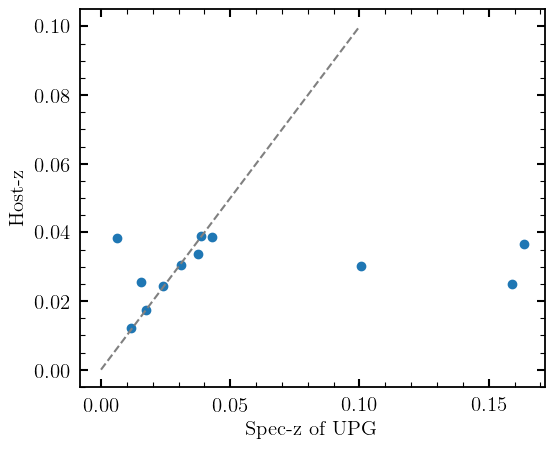

In [253]:
plt.scatter(sorted_specz, specz_cat['host_z'].data)
x = np.linspace(0, 0.1, 100)
plt.plot(x, x, ls='--', c='gray')

plt.xlabel('Spec-z of UPG')
plt.ylabel('Host-z')

In [254]:
len(specz_cat)

12

In [255]:
3 / 12

0.25

In [258]:
flag = ~np.in1d(cat['viz-id'], list(simbad_specz_ids.keys()))
cat = cat[flag]

In [259]:
# Check repeatance
lsbg_coord = SkyCoord(cat['ra'], cat['dec'], unit='deg')

dist_mat = lsbg_coord[None, :].separation(lsbg_coord[:, None]).to(u.deg).value
np.fill_diagonal(dist_mat, 100)

if (dist_mat < (2 * u.arcsec).to(u.deg).value).sum() > 0:
    print('Have overlapping objects')
else:
    print('No overlapping objects')

No overlapping objects


In [260]:
# distance to host
lsbg_coord = SkyCoord(cat['ra'], cat['dec'], unit='deg')
host_coord = SkyCoord(cat['host_RA'], cat['host_DEC'], unit='deg')
dist = lsbg_coord.separation(host_coord).to(u.deg).value
dist_vir = dist / cat['host_r_vir_ang'].data

cat['dist_to_host_rvir'] = dist_vir
cat['SB_eff_avg_g'] = cat['SB_eff_avg'][:, 0]

cat.sort('g-i')

17H - 0H - 3H is observable

2H - 12H

Apr 17: 8h-18h observable

In [261]:
flag = ((cat['ra'] / 15 > 8) & (cat['ra'] / 15 < 16))
flag &= (cat['dec'] < 10)
cat = cat[flag]

In [262]:
len(cat)

16

In [263]:
output_cat = cat[['viz-id', 'ra', 'dec', 'rhalf_spergel', 'SB_eff_avg_g', 'mag', 'host_z', 'g-i']]
output_cat.sort('SB_eff_avg_g')
output_cat

viz-id,ra,dec,rhalf_spergel,SB_eff_avg_g,mag,host_z,g-i
,deg,deg,arcsec,,,,
int64,float64,float64,float64,float64,float64[3],float64,float64
3805,151.1125408,1.8948408,3.6067294255409994,23.308638038810717,18.527620552639252 .. 18.417925474990394,0.030993763357400894,0.10969507764885929
27138,129.6172269,-2.0361118,4.5248061812148315,23.488564219435272,18.215114643244544 .. 17.794108389105915,0.03919384256005287,0.4210062541386294
31639,127.4878328,-1.2739235,5.43158554727518,23.96081608419313,18.290733293053428 .. 17.70535659108629,0.039390645921230316,0.5853767019671389
2965,225.5325325,1.5155803,4.578332349199997,24.112195795104896,18.813209545792827 .. 18.30938338445895,0.03512850031256676,0.5038261613338773
78872,188.2742841,0.8168608,3.7815775270551244,24.23227414165203,19.348459428747432 .. 18.876004439811602,0.031207069754600525,0.4724549889358286
65036,207.8542315,-2.1397243,5.853133223121019,24.30269988428416,18.470308167388392 .. 18.246968163848766,0.01452628429979086,0.22334000353962624
9176,151.3816002,2.6603597,6.1044267453656875,24.46716967512806,18.543495571930457 .. 18.044612982910678,0.022017719224095345,0.49888258901978083
87263,212.431706,-1.8587416,4.097293516926467,24.47464819931165,19.41671314578083 .. 18.9888952204028,0.0295658428221941,0.42781792537802843


In [264]:
obscat = cat[['viz-id', 'ra', 'dec', 'rhalf_spergel', 'SB_eff_avg_g', 'host_z']]

In [265]:
obscat['exptime'] = 10**(0.4 * (obscat['SB_eff_avg_g'].data - 24.5)) * 0.5
obscat.sort('SB_eff_avg_g')

In [266]:
hstack([obscat[['viz-id', 'ra', 'dec', 'rhalf_spergel', 'SB_eff_avg_g', 'host_z']], 
       ],
      ).write(
    '/tigress/jiaxuanl/public_html/galary/catalogs/magellan_proposal/upg_2023A_bright_blue_nospecz.txt', 
    format='ascii', overwrite=True)

(array([4., 0., 2., 0., 1., 0., 2., 0., 5., 2.]),
 array([ 8.49918885,  9.15282018,  9.80645152, 10.46008285, 11.11371418,
        11.76734551, 12.42097684, 13.07460817, 13.7282395 , 14.38187084,
        15.03550217]),
 <BarContainer object of 10 artists>)

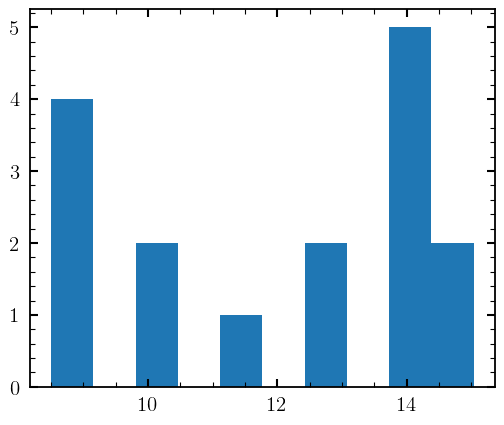

In [267]:
plt.hist(obscat['ra'] / 15)

In [292]:
cat.write('/tigress/jiaxuanl/public_html/galary/catalogs/magellan_proposal/2023A_upg_sample.fits')

---

In [268]:
import astropy.units as u
from astropy.time import Time
from astropy.coordinates import SkyCoord, EarthLocation, AltAz

from astropy.coordinates import SkyCoord
from astroplan import FixedTarget
from astroplan import Observer
from pytz import timezone
from astroplan.plots import plot_airmass 
observer = Observer.at_site('Las Campanas Observatory', timezone=timezone('US/Eastern'))

In [269]:
objs = []
for i in range(len(obscat)):
    coord = SkyCoord(obscat['ra'][i], obscat['dec'][i], unit='deg')
#     obj = FixedTarget(name=str(cat['viz-id'][i]), coord=coord)
    obj = FixedTarget(name=obscat[i]['viz-id'], coord=coord)
    objs.append(obj)

In [270]:
import matplotlib
cmap = matplotlib.cm.get_cmap('RdBu')
colors = [cmap(ra / 360) for ra in obscat['ra'].data]

In [271]:
# colors = ['#9e0142','#d53e4f','#f46d43','#fdae61','#fee08b',
#           '#ffffbf','#e6f598','#abdda4','#66c2a5','#3288bd','#5e4fa2',] * 20

Text(0.5, 1.0, 'Blue UPG observation')

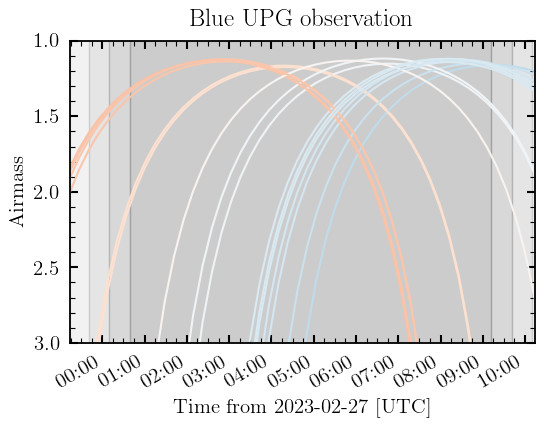

In [272]:
fig, ax = plt.subplots(figsize=(6, 4))
time = Time('2023-02-28 00:00', location=observer.location)
sunset_time = observer.sun_set_time(time, which='nearest')
sunrise_time = observer.sun_rise_time(time, which='nearest')

# observe_time = sunset_time + np.linspace(0, (sunrise_time - sunset_time).to(u.hour).value, 50) * u.hour

observe_time = sunset_time + np.linspace(0, 11, 50) * u.hour

for i in range(len(obscat) - 1):
    plot_airmass(objs[i], observer, observe_time, 
                 style_kwargs={'color': colors[i]}, 
                 brightness_shading=False, use_local_tz=False)
plot_airmass(objs[-1], observer, observe_time, 
             style_kwargs={'color': colors[i]}, 
             brightness_shading=True, use_local_tz=False)
# plot_airmass(objs[1], observer, observe_time)
# plot_airmass(objs[2], observer, observe_time)

# plt.axvline(23)
# plt.legend(shadow=True, loc=2, ncol=2, bbox_to_anchor=(1.1, 0.7))
plt.title('Blue UPG observation')

# plt.savefig('/tigress/jiaxuanl/public_html/galary/catalogs/magellan_proposal/airmass.png', bbox_inches='tight')

Text(0.5, 1.0, 'Blue UPG observation')

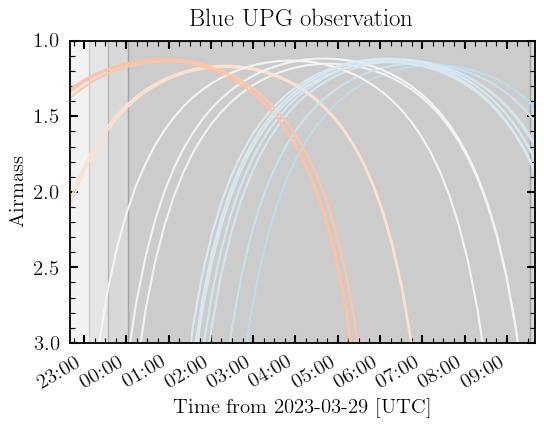

In [273]:
fig, ax = plt.subplots(figsize=(6, 4))
time = Time('2023-03-30 00:00', location=observer.location)
sunset_time = observer.sun_set_time(time, which='nearest')
sunrise_time = observer.sun_rise_time(time, which='nearest')

# observe_time = sunset_time + np.linspace(0, (sunrise_time - sunset_time).to(u.hour).value, 50) * u.hour

observe_time = sunset_time + np.linspace(0, 11, 50) * u.hour

for i in range(len(obscat) - 1):
    plot_airmass(objs[i], observer, observe_time, 
                 style_kwargs={'color': colors[i]}, 
                 brightness_shading=False, use_local_tz=False)
plot_airmass(objs[-1], observer, observe_time, 
             style_kwargs={'color': colors[i]}, 
             brightness_shading=True, use_local_tz=False)
# plot_airmass(objs[1], observer, observe_time)
# plot_airmass(objs[2], observer, observe_time)

# plt.axvline(23)
# plt.legend(shadow=True, loc=2, ncol=2, bbox_to_anchor=(1.1, 0.7))
plt.title('Blue UPG observation')

# plt.savefig('/tigress/jiaxuanl/public_html/galary/catalogs/magellan_proposal/airmass.png', bbox_inches='tight')

---

In [274]:
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
kz.set_matplotlib(style='JL', usetex=True, dpi=100, fontsize=15)

(array([0.54729326, 0.18243109, 0.36486217, 0.36486217, 0.18243109,
        0.72972434, 0.        , 0.        , 0.18243109, 0.36486217]),
 array([2.67847552, 3.02107065, 3.36366577, 3.70626089, 4.04885601,
        4.39145113, 4.73404626, 5.07664138, 5.4192365 , 5.76183162,
        6.10442675]),
 [<matplotlib.patches.Polygon at 0x2aadb7d78fd0>])

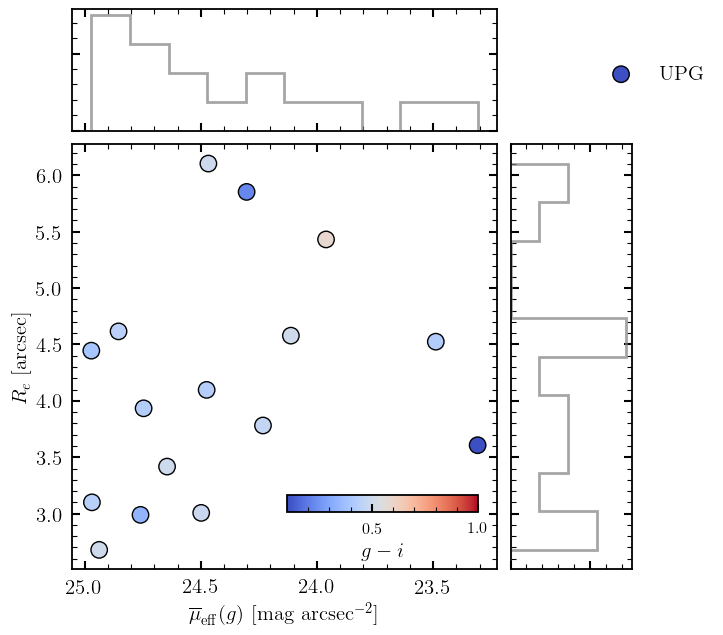

In [275]:
# start with a square Figure
fig = plt.figure(figsize=(7, 7))

gs = fig.add_gridspec(2, 2,  width_ratios=(7, 2), height_ratios=(2, 7),
                      left=0.1, right=0.9, bottom=0.1, top=0.9,
                      wspace=0.05, hspace=0.05)

ax = fig.add_subplot(gs[1, 0])
ax_histx = fig.add_subplot(gs[0, 0], sharex=ax)
ax_histy = fig.add_subplot(gs[1, 1], sharey=ax)
ax_histx.tick_params(axis="x", labelbottom=False)
ax_histx.set_yticklabels([])
# ax_histx.set_xticklabels([])
ax_histy.tick_params(axis="y", labelleft=False)
ax_histy.set_xticklabels([])

sct = ax.scatter(
    cat['SB_eff_avg_g'],
    cat['rhalf_spergel'],
    c=(cat['mag'][:, 0] - cat['mag'][:, 2]),
    vmin=0.1, vmax=1.0,
    cmap='coolwarm',
    marker='o',
    edgecolor='k',
    s=140,
    alpha=1,
    label='UPG'
    )


ax.legend(loc='upper right', bbox_to_anchor=(1.55, 1.25))

cax = inset_axes(ax, width="45%", height="4%", 
                 loc='lower right', bbox_to_anchor=(-0.02, 0.11, 1, 1),
                 bbox_transform=ax.transAxes) 
plt.colorbar(sct, cax=cax, label='$g-i$',
             orientation='horizontal')
cax.tick_params(labelsize=11.5)

# ax.set_xlim(29, 24)
# ax.set_ylim(1.6, 14)
ax.invert_xaxis()
ax.set_xlabel(r'$\overline{\mu}_{\rm eff}(g)\ [\rm mag\ arcsec^{-2}]$')
ax.set_ylabel(r'$R_e\ [\rm arcsec]$')

ax_histx.hist(cat['SB_eff_avg_g'], lw=2,
              histtype='step', density=True, color='gray', 
              alpha=0.7, label='$g-i > 0.7$')
ax_histy.hist(cat['rhalf_spergel'], lw=2,
              histtype='step', density=True, orientation='horizontal', color='gray', alpha=0.7)
# ax_histy.set_xscale('log')

# show redshift
# cax2 = inset_axes(ax, width='37%', height='18%', 
#                   loc='upper left', 
#                   bbox_to_anchor=(0.06, -0.23, 1, 1),
#                   bbox_transform=ax.transAxes)
# cax2.hist(cat['host_z'], histtype='step', density=True, color='k', alpha=0.7)
# cax2.set_title('Host redshift', fontsize=12, pad=3)
# cax2.set_yticklabels([])
# cax2.set_xticks([0.01, 0.02, 0.03, 0.04])
# cax2.tick_params(axis='both', which='both', length=3, labelsize=10, pad=4)

# plt.savefig('/tigress/jiaxuanl/public_html/galary/catalogs/magellan_proposal/sample_summary.png')

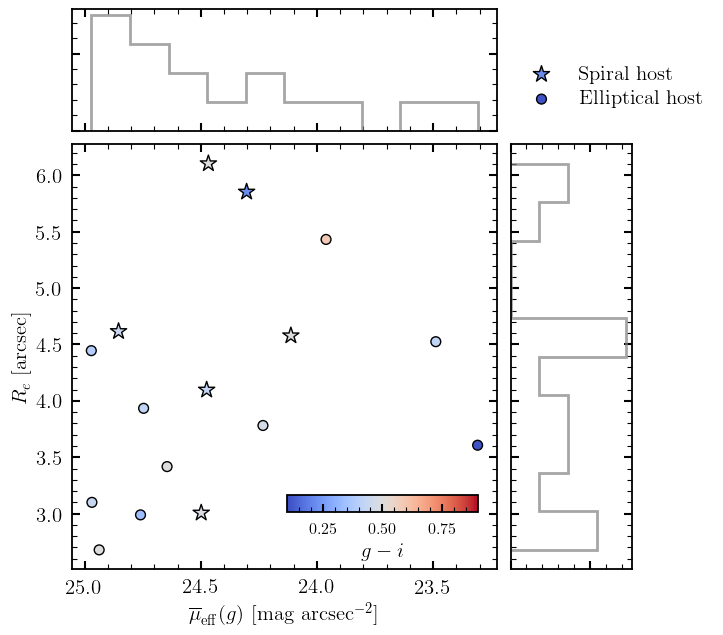

In [283]:
# start with a square Figure
fig = plt.figure(figsize=(7, 7))

gs = fig.add_gridspec(2, 2,  width_ratios=(7, 2), height_ratios=(2, 7),
                      left=0.1, right=0.9, bottom=0.1, top=0.9,
                      wspace=0.05, hspace=0.05)

ax = fig.add_subplot(gs[1, 0])
ax_histx = fig.add_subplot(gs[0, 0], sharex=ax)
ax_histy = fig.add_subplot(gs[1, 1], sharey=ax)
ax_histx.tick_params(axis="x", labelbottom=False)
ax_histx.set_yticklabels([])
# ax_histx.set_xticklabels([])
ax_histy.tick_params(axis="y", labelleft=False)
ax_histy.set_xticklabels([])

flag = (cat['host_spiral'] == 1)
sct = ax.scatter(
    cat['SB_eff_avg_g'][flag],
    cat['rhalf_spergel'][flag],
    c=(cat['mag'][:, 0] - cat['mag'][:, 2])[flag],
    vmin=0.1, vmax=0.9,
    cmap='coolwarm',
    marker='*',
    edgecolor='k',
    s=150,
    alpha=1,
    label='Spiral host'
    )

sct = ax.scatter(
    cat['SB_eff_avg_g'][~flag],
    cat['rhalf_spergel'][~flag],
    c=(cat['mag'][:, 0] - cat['mag'][:, 2])[~flag],
    vmin=0.1, vmax=0.9,
    cmap='coolwarm',
    edgecolor='k',
    s=50,
    alpha=1,
    label='Elliptical host'
    )

ax.legend(loc='upper right', bbox_to_anchor=(1.55, 1.25))

cax = inset_axes(ax, width="45%", height="4%", 
                 loc='lower right', bbox_to_anchor=(-0.02, 0.11, 1, 1),
                 bbox_transform=ax.transAxes) 
plt.colorbar(sct, cax=cax, label='$g-i$',
             orientation='horizontal')
cax.tick_params(labelsize=11.5)

# ax.set_xlim(29, 24)
# ax.set_ylim(1.6, 14)
ax.invert_xaxis()
ax.set_xlabel(r'$\overline{\mu}_{\rm eff}(g)\ [\rm mag\ arcsec^{-2}]$')
ax.set_ylabel(r'$R_e\ [\rm arcsec]$')

ax_histx.hist(cat['SB_eff_avg_g'], lw=2,
              histtype='step', density=True, color='gray', 
              alpha=0.7, label='$g-i > 0.7$')
ax_histy.hist(cat['rhalf_spergel'], lw=2,
              histtype='step', density=True, orientation='horizontal', color='gray', alpha=0.7)
# ax_histy.set_xscale('log')

# show redshift
# cax2 = inset_axes(ax, width='37%', height='18%', 
#                   loc='upper left', 
#                   bbox_to_anchor=(0.06, -0.23, 1, 1),
#                   bbox_transform=ax.transAxes)
# cax2.hist(cat['host_z'], histtype='step', density=True, color='k', alpha=0.7)
# cax2.set_title('Host redshift', fontsize=12, pad=3)
# cax2.set_yticklabels([])
# cax2.set_xticks([0.01, 0.02, 0.03, 0.04])
# cax2.tick_params(axis='both', which='both', length=3, labelsize=10, pad=4)

plt.savefig('/tigress/jiaxuanl/public_html/galary/catalogs/magellan_proposal/2023A_sample_summary.png')

##### Write to Tex

In [287]:
tex_table = hstack([cat[['viz-id', 'ra', 'dec']], 
        Column(data=cat['rhalf_spergel'], name=r'$R_e$'),
        Column(data=cat['SB_eff_avg'][:, 0], name=r'$\overline{\mu}_e(g)$'), 
        Column(data=cat['mag'][:, 0], name=r'$g$'),
        Column(data=cat['mag'][:, 0] - cat['mag'][:, 2], name=r'$g-i$'),
        Column(data=cat['host_z'], name=r'$z_{\mathrm{host}}$'),
        Column(data=cat['dist_to_host_rvir'], name=r'$D_{\rm host}$'),
        Column(data=['S' if t == 1 else 'E' for t in cat['host_spiral']], name='Host type')],
      )
tex_table.rename_column('viz-id', 'ID')
coords = SkyCoord(cat['ra'], cat['dec'], unit='deg')
tex_table['ra'] = (coords.ra / 15).to_string(sep=':', precision=0, fields=3)
tex_table['ra'] = ['0' + t if len(t) == 7 else t for t in tex_table['ra']]
tex_table['dec'] = np.array([f'+{t:.4f}' if t > 0 else f'{t:.4f}' for t in tex_table['dec']])
tex_table.rename_column('ra', 'R.A.')
tex_table.rename_column('dec', 'Dec.')

tex_table[r'$R_e$'] = [f'{t:.2f}' for t in tex_table[r'$R_e$']]
tex_table[r'$g$'] = [f'{t:.2f}' for t in tex_table[r'$g$']]
tex_table[r'$g-i$'] = [f'{t:.2f}' for t in tex_table[r'$g-i$']]
tex_table[r'$\overline{\mu}_e(g)$'] = [f'{t:.2f}' for t in tex_table[r'$\overline{\mu}_e(g)$']]
tex_table[r'$z_{\mathrm{host}}$'] = [f'{t:.4f}' for t in tex_table[r'$z_{\mathrm{host}}$']]
tex_table[r'$D_{\rm host}$'] = [f'{t:.2f}' for t in tex_table[r'$D_{\rm host}$']]

In [288]:
tex_table

ID,R.A.,Dec.,$R_e$,$\overline{\mu}_e(g)$,$g$,$g-i$,$z_{\mathrm{host}}$,$D_{\rm host}$,Host type
int64,str8,str7,str4,str5,str5,str4,str6,str4,str1
3805,10:04:27,+1.8948,3.61,23.31,18.53,0.11,0.0310,0.80,E
65036,13:51:25,-2.1397,5.85,24.30,18.47,0.22,0.0145,0.58,S
88167,08:32:11,-1.1719,2.99,24.76,20.39,0.34,0.0309,0.97,E
30014,13:58:46,-2.2781,4.45,24.97,19.74,0.39,0.0244,0.92,E
27138,08:38:28,-2.0361,4.52,23.49,18.22,0.42,0.0392,0.95,E
34340,12:25:41,-2.3957,3.93,24.75,19.78,0.42,0.0298,0.84,E
87263,14:09:44,-1.8587,4.10,24.47,19.42,0.43,0.0296,0.59,S
36359,13:56:24,-0.1309,3.10,24.97,20.52,0.43,0.0297,0.98,E
76692,11:38:41,-1.0384,4.62,24.85,19.54,0.44,0.0208,0.90,S


In [289]:
from astropy.io import ascii

In [290]:
ascii.write(tex_table, 
            Writer=ascii.Latex, 
               latexdict={'preamble': r'\begin{center}',
                       'tablefoot': r'\end{center}',
                       'tabletype': 'table*',
                          'units': {r'$R_e$': '(arcsec)', 
                                    r'$\overline{\mu_e}(g)$': r'(mag arcsec$^{-2}$)',
                                    r'$g$': '(mag)',
                                    r'$g-i$': '(mag)',
                                    r'$D_{\rm host}$': "($R_{\mathrm{vir}}$)"}
                         })

\begin{table*}
\begin{center}
\begin{tabular}{cccccccccc}
ID & R.A. & Dec. & $R_e$ & $\overline{\mu}_e(g)$ & $g$ & $g-i$ & $z_{\mathrm{host}}$ & $D_{\rm host}$ & Host type \\
 &  &  & (arcsec) &  & (mag) & (mag) &  & ($R_{\mathrm{vir}}$) &  \\
3805 & 10:04:27 & +1.8948 & 3.61 & 23.31 & 18.53 & 0.11 & 0.0310 & 0.80 & E \\
65036 & 13:51:25 & -2.1397 & 5.85 & 24.30 & 18.47 & 0.22 & 0.0145 & 0.58 & S \\
88167 & 08:32:11 & -1.1719 & 2.99 & 24.76 & 20.39 & 0.34 & 0.0309 & 0.97 & E \\
30014 & 13:58:46 & -2.2781 & 4.45 & 24.97 & 19.74 & 0.39 & 0.0244 & 0.92 & E \\
27138 & 08:38:28 & -2.0361 & 4.52 & 23.49 & 18.22 & 0.42 & 0.0392 & 0.95 & E \\
34340 & 12:25:41 & -2.3957 & 3.93 & 24.75 & 19.78 & 0.42 & 0.0298 & 0.84 & E \\
87263 & 14:09:44 & -1.8587 & 4.10 & 24.47 & 19.42 & 0.43 & 0.0296 & 0.59 & S \\
36359 & 13:56:24 & -0.1309 & 3.10 & 24.97 & 20.52 & 0.43 & 0.0297 & 0.98 & E \\
76692 & 11:38:41 & -1.0384 & 4.62 & 24.85 & 19.54 & 0.44 & 0.0208 & 0.90 & S \\
78872 & 12:33:06 & +0.8169 & 3.78 & 2

In [103]:
gal1 = selected_cat[selected_cat['viz-id'] == 75619]

In [104]:
gal2 = selected_cat[selected_cat['viz-id'] == 29808]

In [105]:
gal1_coord = SkyCoord(gal1['ra'], gal1['dec'], unit='deg')
gal2_coord = SkyCoord(gal2['ra'], gal2['dec'], unit='deg')

In [106]:
gal1_coord.separation(gal2_coord)

<Angle [0.01149488] deg>

In [ ]:
41.4

In [110]:
gal1['host_ang_diam_dist'].data * 41.4 / 206265 * 1000

array([15.38789361])

In [114]:
(13*u.hourangle + 2 * u.arcmin + 16 * u.arcsec).to(u.hourangle).to(u.deg)

<Quantity 195.03777778 deg>

In [116]:
(13 + 2 / 60 + 16 / 3600) * 15

195.56666666666666

In [115]:
(28 * u.deg + 57 * u.arcmin + 17 * u.arcsec).to(u.deg)

<Quantity 28.95472222 deg>

##### Exp time

In [122]:
def calc_exp(SB):
    return 10**(0.4 * (SB - 24.5)) * (10 / 6.5)**2 * (0.3/0.2) * 20 * u.min

$$t_{LDSS3} / t_{LRIS} = (D_{m} / D_{k})^{-2} \cdot (\epsilon_{m} / \epsilon_{k})^{-1} \cdot 10^{0.4 (\mu - 24.5)}$$

$$t_{LDSS3} / t_{LRIS} = (6.5 / 10)^{-2} \cdot (0.1 / 0.3)^{-1} \cdot 10^{0.4 (\mu - 24.5)}$$

In [123]:
calc_exp(24.5).to(u.hour)

<Quantity 1.18343195 h>

In [151]:
calc_exp(25.5).to(u.hour)

<Quantity 2.97264666 h>

In [158]:
(selected_cat['g-i'] < 0.75).sum()

5

In [153]:
exptime = calc_exp(selected_cat['SB_eff_avg_g']).to(u.hour)
exptime[selected_cat['g-i'] < 0.75] = 0.5 * u.hour

In [154]:
exptime

<Quantity [1.25678179, 0.5       , 0.5       , 0.5       , 1.96054604,
           2.04492744, 2.05142035, 0.5       , 2.18646428, 0.5       ,
           2.31985537, 2.50269111, 2.69731946, 2.71176347, 2.79421843] h>

In [155]:
exptime.sum()

<Quantity 25.02598773 h>

In [149]:
np.array([3968, 3933]) * (1 + 0.04)

array([4126.72, 4090.32])

In [150]:
10800 / 3600

3.0

In [125]:
300000 / 450

666.6666666666666

In [128]:
1 / 509 * 300000 / 2.355

250.27217098594718

In [129]:
1900 / 5

380.0

In [135]:
R = 4100 * 0.75 / 5
300000 / R / 2.355

207.13582932007665

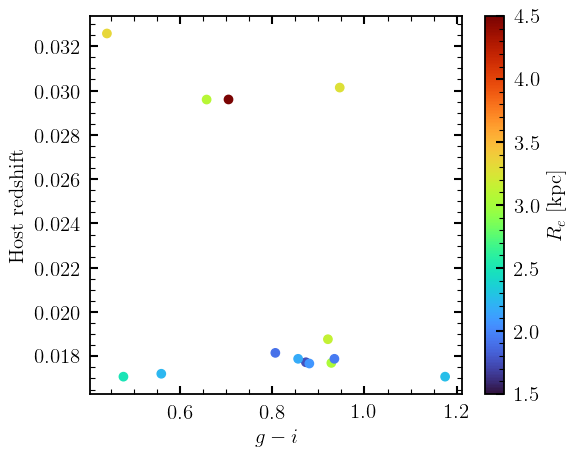

In [273]:
plt.scatter(cat['mag'][:, 0] - cat['mag'][:, 2], 
            cat['host_z'], 
            c=cat['rhalf_circularized_phys'], vmin=1.5, vmax=4.5)
plt.xlabel('$g-i$')
plt.ylabel('Host redshift')
plt.colorbar(label='$R_e$ [kpc]')

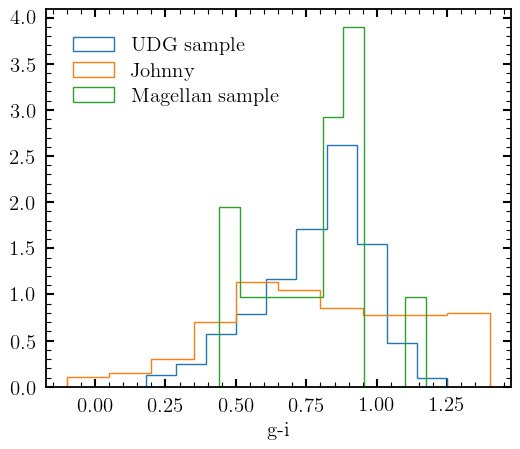

In [274]:
johnny = Table.read('./Catalog/Greco_S18A_lsbg.fits')
plt.hist(udg_cat['mag'][:, 0] - udg_cat['mag'][:, 2], histtype='step', density=True, label='UDG sample')
plt.hist(johnny['g-i'], histtype='step', density=True, label='Johnny')
plt.hist(cat['mag'][:, 0] - cat['mag'][:, 2], density=True, histtype='step', label='Magellan sample')
plt.xlabel('g-i')
plt.legend(loc='upper left')

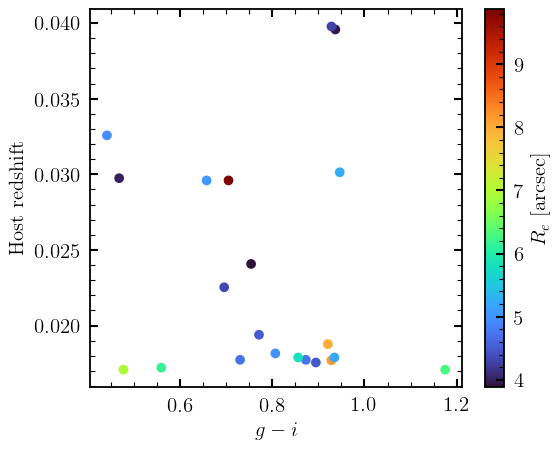

In [245]:
plt.scatter(cat['mag'][:, 0] - cat['mag'][:, 2], 
            cat['host_z'], 
            c=cat['rhalf_spergel'] * 0.168)
plt.xlabel('$g-i$')
plt.ylabel('Host redshift')
plt.colorbar(label='$R_e$ [arcsec]')

In [196]:
hstack([cat[['viz-id', 'ra', 'dec']], 
        Column(data=np.round(cat['rhalf_spergel'] * 0.168, 2), name='rhalf_'),
        Column(data=np.round(cat['SB_eff_avg'][:, 0], 2), name='SB_eff_avg_g'), 
        Column(data=np.round(cat['mag'][:, 0], 2), name='g_mag'),
        Column(data=np.round(cat['mag'][:, 0] - cat['mag'][:, 2], 2), name='g-i'),
       Column(data=np.round(cat['dist_to_host_rvir'], 2), name='dist2host_rvir')]
      ).write(
    '/tigress/jiaxuanl/public_html/galary/catalogs/magellan_proposal/udg_cat_latex.tex', 
    format='ascii.latex')